---
# combine aggregated spills files
---

In [1]:
import os
import pathlib
import yaml
import numpy
import pandas
import xarray
import h5netcdf
from datetime import datetime
from glob import glob
import time
from matplotlib import pyplot as plt, cm, colors
import matplotlib as mpl
mpl.rc('font', size=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')


### load runlist used to create aggregated files 

In [2]:
yaml_file=pathlib.Path(
     '/home/rmueller/projects/def-allen/rmueller/MIDOSS/Visualization',
     'MOHID_results_locations_07102021_15:52:22.yaml')
with yaml_file.open("rt") as f:
    run_paths = yaml.safe_load(f) 

### create list of aggregated files by oil type

In [3]:
output_netcdf_dir=pathlib.Path('/scratch/rmueller/MIDOSS/Results/test_0906') 
beaching_files = sorted(glob(os.path.join(output_netcdf_dir,"beaching_*")))
surface_files = sorted(glob(os.path.join(output_netcdf_dir,"surface_*")))

In [4]:
beaching_files

['/scratch/rmueller/MIDOSS/Results/test_0906/beaching_bunker_0-50.nc',
 '/scratch/rmueller/MIDOSS/Results/test_0906/beaching_bunker_50-100.nc',
 '/scratch/rmueller/MIDOSS/Results/test_0906/beaching_diesel_0-50.nc',
 '/scratch/rmueller/MIDOSS/Results/test_0906/beaching_diesel_50-100.nc']

In [5]:
# Create dictionary with indices of file to aggregate by oil type
# (Identifying indices will eventually be coded in)
file_idx = {}
file_idx['bunker']=[0,1]
file_idx['diesel']=[2,3]

# Beaching

In [6]:
x0=xarray.open_dataset(beaching_files[file_idx['bunker'][0]])
x1=xarray.open_dataset(beaching_files[file_idx['bunker'][1]])

In [7]:
xsum = x0 + x0

In [8]:
[*x0]

['BeachPresence',
 'BeachPresence_24h',
 'BeachPresence_24h_to_72h',
 'BeachPresence_72h_to_168h',
 'MeanBeachTime',
 'MinBeachTime',
 'TotalBeachVolume']

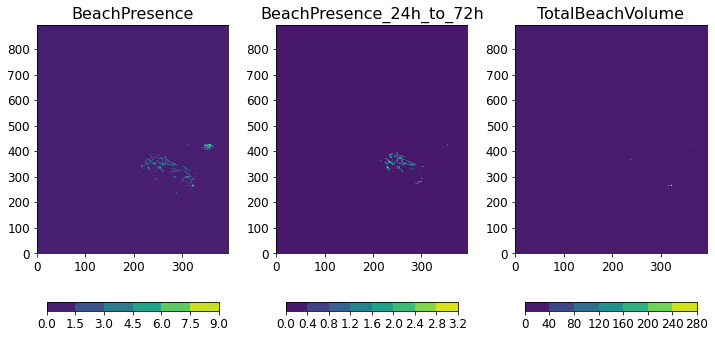

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
cs0=axs[0].contourf(x0['BeachPresence'])
cs1=axs[1].contourf(x0['BeachPresence_24h_to_72h'])
cs2=axs[2].contourf(x0['TotalBeachVolume'])
axs[0].set_title('BeachPresence')
axs[1].set_title('BeachPresence_24h_to_72h')
axs[2].set_title('TotalBeachVolume')
fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='horizontal')

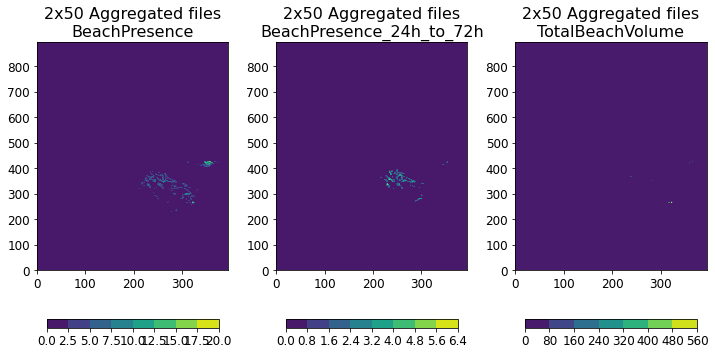

In [10]:
from matplotlib import pyplot as plt, cm, colors
fig, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
cs0=axs[0].contourf(xsum['BeachPresence'])
cs1=axs[1].contourf(xsum['BeachPresence_24h_to_72h'])
cs2=axs[2].contourf(xsum['TotalBeachVolume'])
axs[0].set_title('2x50 Aggregated files\nBeachPresence')
axs[1].set_title('2x50 Aggregated files\nBeachPresence_24h_to_72h')
axs[2].set_title('2x50 Aggregated files\nTotalBeachVolume')
fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='horizontal')

### Take-away: Can use simple '+' for aggregating these xarray datasets

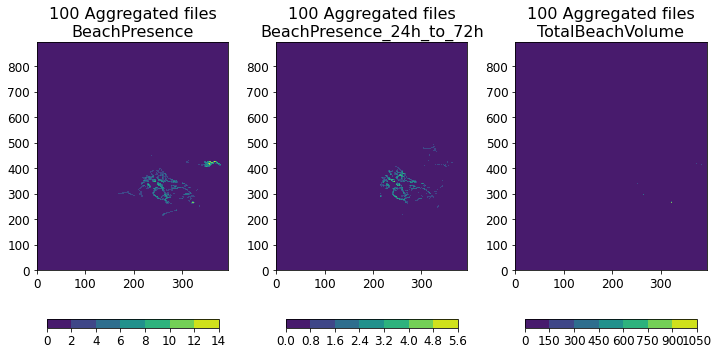

In [11]:
xsum = x0 + x1
from matplotlib import pyplot as plt, cm, colors
fig, axs = plt.subplots(1, 3, figsize=(12, 6), gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
cs0=axs[0].contourf(xsum['BeachPresence'])
cs1=axs[1].contourf(xsum['BeachPresence_24h_to_72h'])
cs2=axs[2].contourf(xsum['TotalBeachVolume'])
axs[0].set_title('100 Aggregated files\nBeachPresence')
axs[1].set_title('100 Aggregated files\nBeachPresence_24h_to_72h')
axs[2].set_title('100 Aggregated files\nTotalBeachVolume')
fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='horizontal')

## Print min/max values to evaluate range

In [12]:
for variable in [*x0]:
    variable
    print(variable,': ', x0[variable].min().values.item(),
          '-', x0[variable].max().values.item())

BeachPresence :  0 - 9
BeachPresence_24h :  0 - 9
BeachPresence_24h_to_72h :  0 - 3
BeachPresence_72h_to_168h :  0 - 3
MeanBeachTime :  1.0 - 7.0
MinBeachTime :  1.0 - 7.0
TotalBeachVolume :  0.0 - 278.69738889543623


# Surface

In [13]:
surface_files

['/scratch/rmueller/MIDOSS/Results/test_0906/surface_bunker_0-50.nc',
 '/scratch/rmueller/MIDOSS/Results/test_0906/surface_bunker_50-100.nc',
 '/scratch/rmueller/MIDOSS/Results/test_0906/surface_diesel_0-50.nc',
 '/scratch/rmueller/MIDOSS/Results/test_0906/surface_diesel_50-100.nc']

In [14]:
sfc = {}
sfc[0]=xarray.open_dataset(surface_files[file_idx['bunker'][0]])
sfc[1]=xarray.open_dataset(surface_files[file_idx['bunker'][1]])

In [15]:
[*sfc[0]]

['SurfaceConcentration_SumSum',
 'SurfaceDissolution_SumSum',
 'SurfacePresence',
 'SurfaceVolume_MaxSum',
 'SurfaceVolume_SumSum',
 'SurfaceVolume_SumSum_24h',
 'SurfaceVolume_SumSum_24h_to_72h',
 'SurfaceVolume_SumSum_72h_to_168h']

###  Aggregate n and (n-1) file

In [16]:
sfc_aggregated = sfc[0] + sfc[1]
#sfc_aggregated = sfc[1]

In [17]:
[*sfc[0]][1]

'SurfaceDissolution_SumSum'

In [18]:
limits={}
limits['SurfacePresence']=(0,20)
limits['SurfacePresence'][1]

20

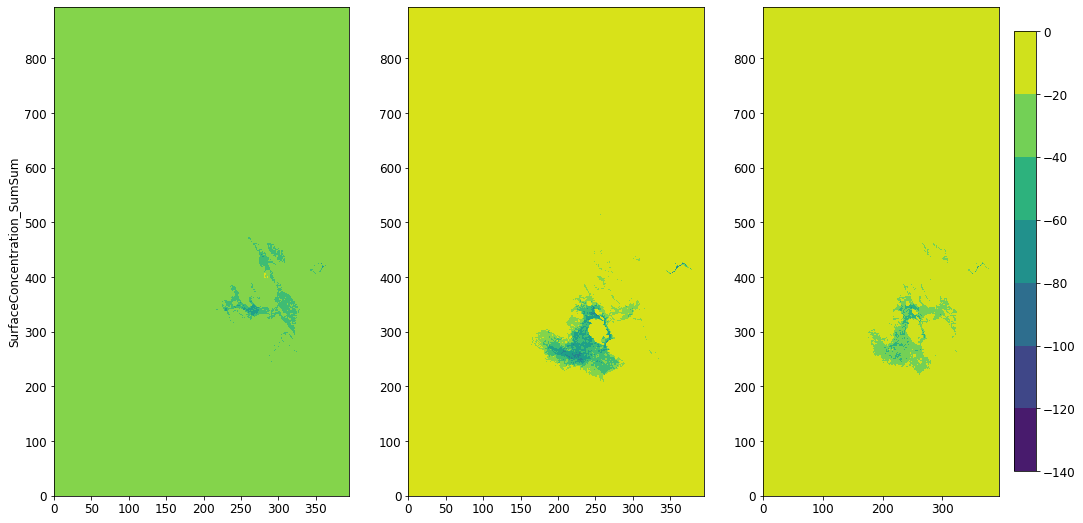

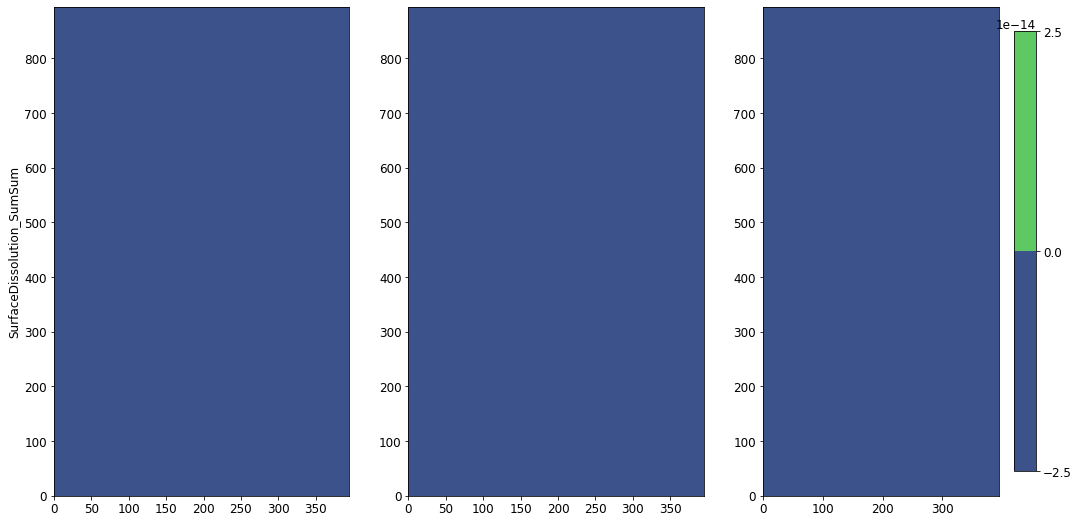

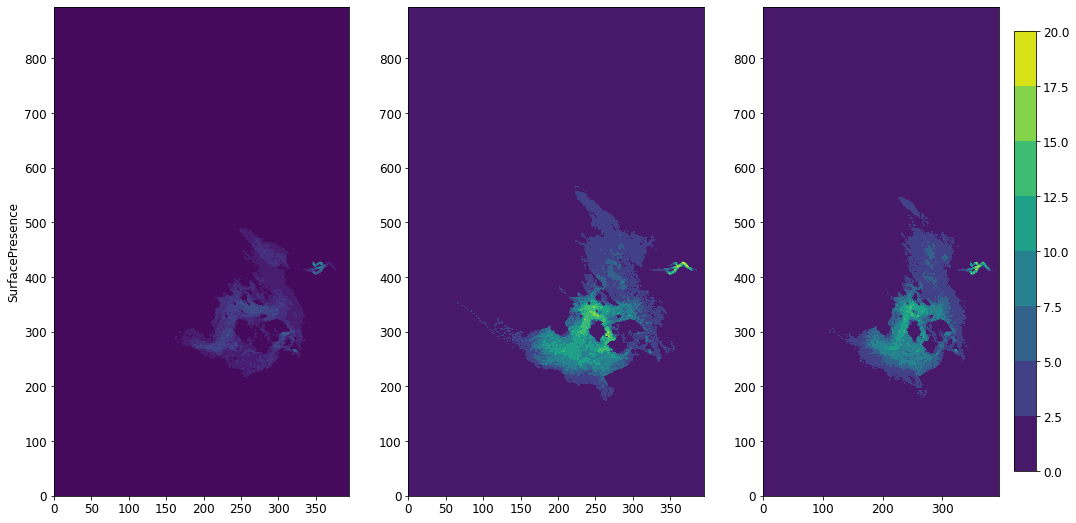

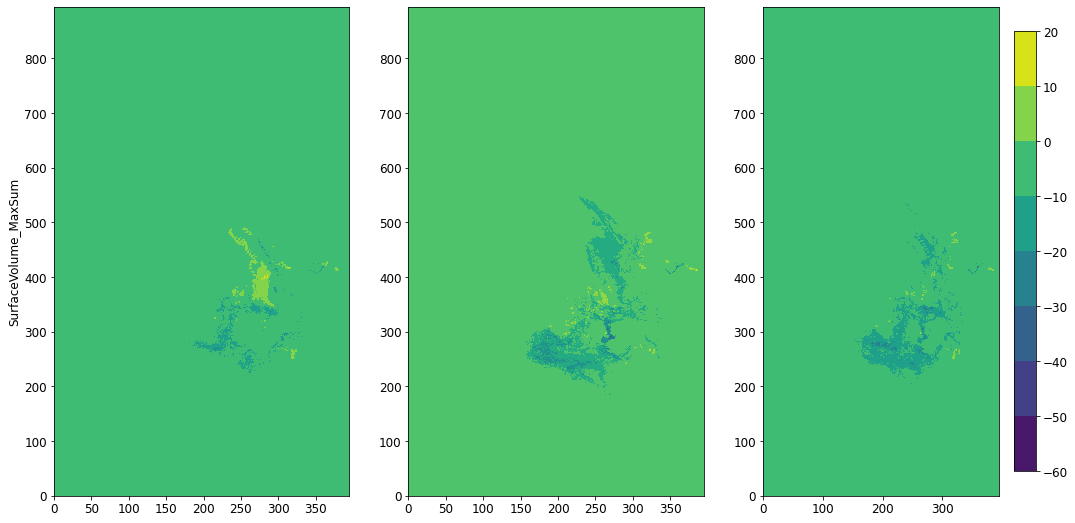

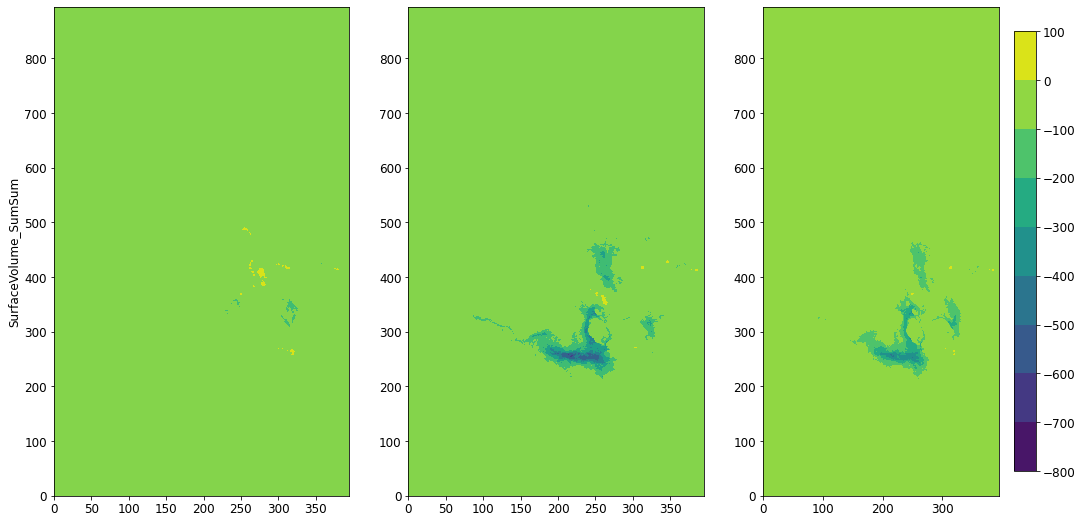

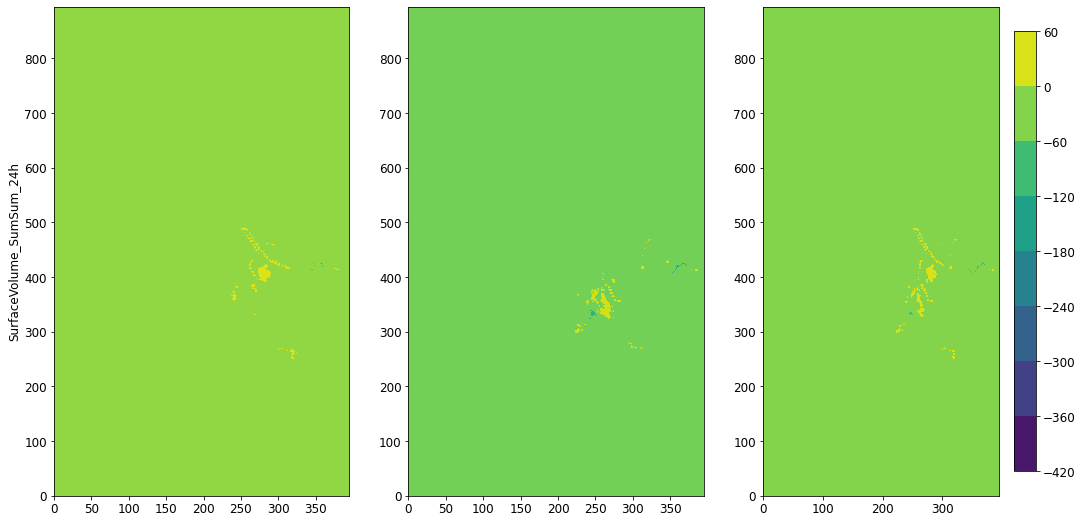

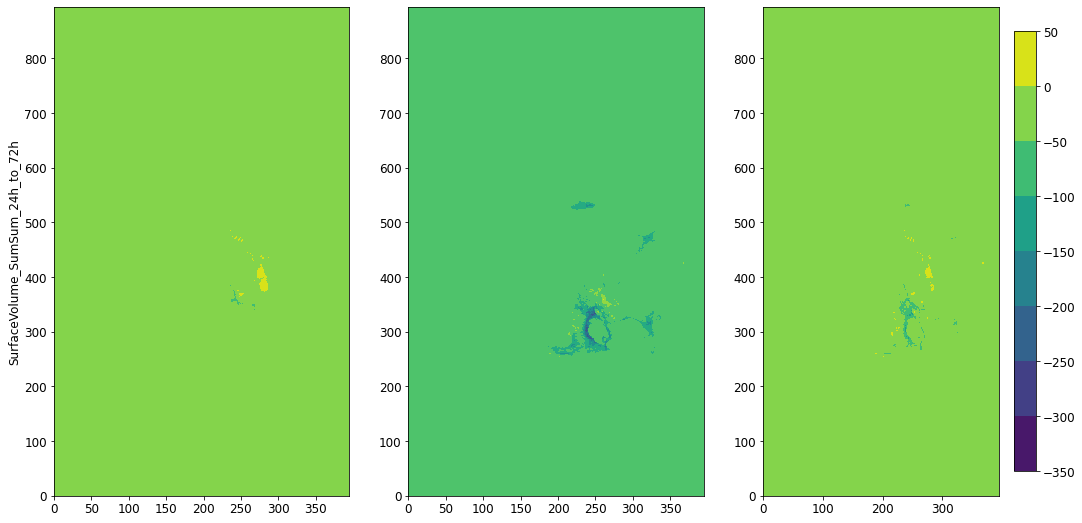

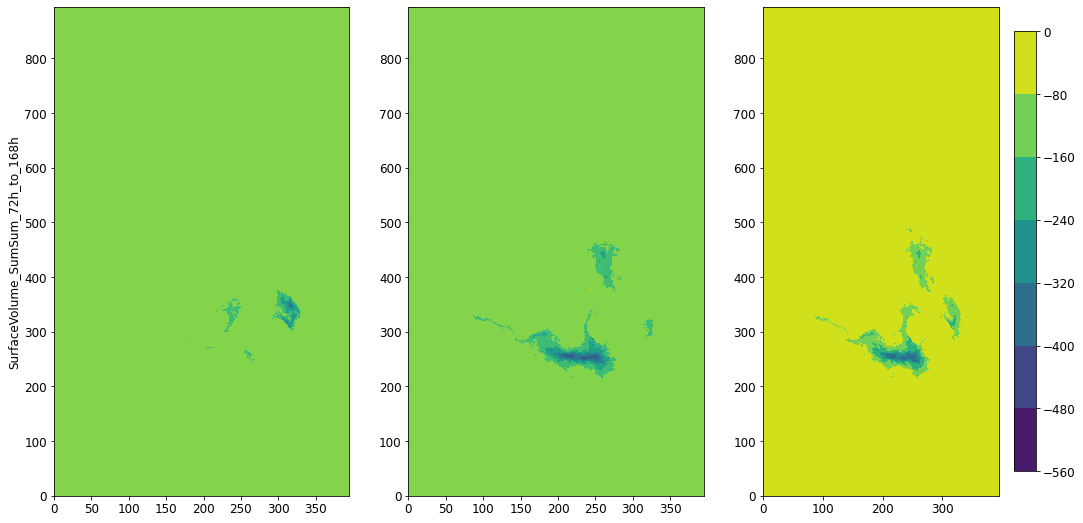

In [19]:
for var_idx,variable in enumerate([*sfc[0]]):
    fig,axs = plt.subplots(
        1, 3, figsize=(18, 9), 
        subplot_kw={"facecolor": "white"}
    )
    fig.subplots_adjust(hspace=0.5)
    if variable=='SurfacePresence':
        cs0=axs[0].contourf(sfc[0][variable], 
            levels=numpy.linspace(limits[variable][0],limits[variable][1],20))
    else:
        cs0=axs[0].contourf(sfc[0][variable])
    
    cs1=axs[1].contourf(sfc[1][variable])
    cs2=axs[2].contourf(sfc_aggregated[variable])
    axs[0].set_ylabel(variable)
    # axs[1].set_title('BeachPresence_24h_to_72h')
    # axs[2].set_title('TotalBeachVolume')
    # fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
    # fig.colorbar(cs0, ax=axs[1], shrink=0.9, orientation='horizontal')
    fig.colorbar(cs2, ax=axs[2], shrink=0.9, orientation='vertical')

## Compare two-ways of aggregating surface presence

In [20]:
sfcPresence_aggregated = sfc[0]['SurfacePresence'] + sfc[1]['SurfacePresence']
sum(sum(sfc_aggregated[variable] - sfcPresence_aggregated)).values.item()

-2951964.1646356466

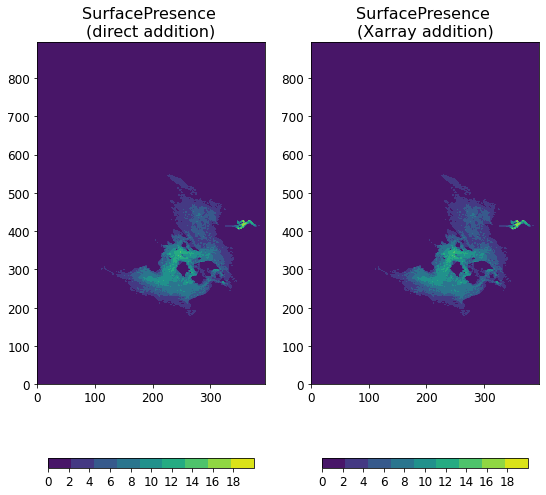

In [21]:
variable = 'SurfacePresence'
fig,axs = plt.subplots(
    1, 2, figsize=(9, 9), 
    subplot_kw={"facecolor": "white"}
)
fig.subplots_adjust(hspace=0.5)
cs0=axs[0].contourf(sfcPresence_aggregated, 
        levels=numpy.linspace(limits[variable][0],limits[variable][1],10))
cs1=axs[1].contourf(sfc_aggregated[variable],
        levels=numpy.linspace(limits[variable][0],limits[variable][1],10))

axs[0].set_title('SurfacePresence \n(direct addition)')
axs[1].set_title('SurfacePresence \n(Xarray addition)')
cbar1=fig.colorbar(cs0, ax=axs[0], shrink=0.9, orientation='horizontal')
cbar2=fig.colorbar(cs1, ax=axs[1], shrink=0.9, orientation='horizontal')
labels = numpy.arange(limits[variable][0],limits[variable][1],2)
cbar1.set_ticks(labels)
cbar2.set_ticks(labels)
#cbar.ax.set_xticklabels(labels, rotation=45)

## Evaluate surface dissolution, concentration and volume in the top 5 largest spills in these aggregations 

In [22]:
First100 = {}
for oil in ['diesel','bunker']:
    First100[oil] = run_paths[oil][0:100]

In [23]:
First100['diesel'][0]

'/scratch/dlatorne/MIDOSS/runs/monte-carlo/near-BP_10th-100_2021-09-25T162640/results/near-BP_10th-100-1/Lagrangian_diesel-1_near-BP_10th-100-1.nc'

In [24]:
First100['diesel'][0].split('/')[0:-1]

['',
 'scratch',
 'dlatorne',
 'MIDOSS',
 'runs',
 'monte-carlo',
 'near-BP_10th-100_2021-09-25T162640',
 'results',
 'near-BP_10th-100-1']

In [25]:
First100['diesel'][0].split('_')[-3]

'diesel-1'

In [26]:
"/".join(First100['diesel'][0].split("/")[:-1]) 

'/scratch/dlatorne/MIDOSS/runs/monte-carlo/near-BP_10th-100_2021-09-25T162640/results/near-BP_10th-100-1'

### Get spill volumes and sort spills to get 5 largest spills by oil type

In [41]:
big5_spills={}
for oil in ['diesel','bunker']:
    volume = {}
    volume[oil]={}
    volume[oil]['volume']=[]
    for idx,ncfile in enumerate(First100[oil]):
        directory = "/".join(ncfile.split("/")[:-1]) 
        oil_tag = First100[oil][idx].split('_')[-3]
        # Open the Lagrangian file used for spill
        Lagrangian_file = directory+'/Lagrangian_'+oil_tag+'.dat'
        with open(Lagrangian_file, 'r') as f:
            for line in f:
                if 'POINT_VOLUME              :' in line: 
                    # select spill volume quantity after ':'
                    spillvolume = line.split(':')[-1].split('\n')[0]
                    # convert to float for "sort_values" to work properly
                    volume[oil]['volume'].append(float(spillvolume)) 
        big5_spills[oil] = pandas.DataFrame.from_dict(
            volume[oil]).sort_values('volume',ascending=False)[0:5]

In [45]:
big5_spills['diesel']

,volume
30,4953.009484
12,649.588420
93,296.522276
67,210.232635
72,202.045269


### Use indices from big5_spills to open and plot output from the top 5 spills

In [28]:
big5_spills[oil].index.values

array([77, 76, 81,  6, 45])

In [59]:
try: 
    TopSpills = pandas.read_csv('/home/rmueller/projects/def-allen/rmueller/MIDOSS/analysis-rachael/notebooks/monte_carlo_dev/TopSpills_df.csv')
except:
    ## Generate "TopSpills_df.csv"
    ## This section takes 10 minutes on 5210 Mb
    %%time
    vars2plot= ['Dissolution_3D','OilConcentration_3D','OilWaterColumnOilVol_3D']
    oil_type=[]
    spill_index=[]
    spill_volume=[]
    #variable_list = []
    mn={}
    mx={}
    for variable in vars2plot:
        mn[variable] = []
        mx[variable] = []

    for oil in ['diesel','bunker']:
        # loop through indices of the 5 largest spills in the first 100 spill files
        for idx in big5_spills[oil].index.values:
            spill_xr=xarray.open_dataset(First100[oil][idx])
            oil_type.append(oil)
            spill_index.append(idx)
            spill_volume.append(big5_spills[oil]['volume'][idx])
            for variable in vars2plot:
                print(f'[{oil}-{idx}-{variable}]')     
                mn[variable].append(spill_xr[variable][:,39,:,:].min().values.item())
                mx[variable].append(spill_xr[variable][:,39,:,:].max().values.item())
            spill_xr.close()
    TopSpills = {'oil_type':oil_type, 'spill_volume':spill_volume,
        'MinSfcDiss':mn['Dissolution_3D'], 'MaxSfcDiss':mx['Dissolution_3D'],
        'MinSfcConc':mn['OilConcentration_3D'], 'MaxSfcConc':mx['OilConcentration_3D'],
        'MinSfcVol':mn['OilWaterColumnOilVol_3D'], 'MaxSfcVol':mx['OilWaterColumnOilVol_3D']}
    TopSpills_df = pandas.DataFrame(TopSpills)
    TopSpills_df.to_csv('TopSpills_df.csv')

[diesel-30-Dissolution_3D]
[diesel-30-OilConcentration_3D]
[diesel-30-OilWaterColumnOilVol_3D]
[diesel-12-Dissolution_3D]
[diesel-12-OilConcentration_3D]
[diesel-12-OilWaterColumnOilVol_3D]
[diesel-93-Dissolution_3D]
[diesel-93-OilConcentration_3D]
[diesel-93-OilWaterColumnOilVol_3D]
[diesel-67-Dissolution_3D]
[diesel-67-OilConcentration_3D]
[diesel-67-OilWaterColumnOilVol_3D]
[diesel-72-Dissolution_3D]
[diesel-72-OilConcentration_3D]
[diesel-72-OilWaterColumnOilVol_3D]
[bunker-77-Dissolution_3D]
[bunker-77-OilConcentration_3D]
[bunker-77-OilWaterColumnOilVol_3D]
[bunker-76-Dissolution_3D]
[bunker-76-OilConcentration_3D]
[bunker-76-OilWaterColumnOilVol_3D]
[bunker-81-Dissolution_3D]
[bunker-81-OilConcentration_3D]
[bunker-81-OilWaterColumnOilVol_3D]
[bunker-6-Dissolution_3D]
[bunker-6-OilConcentration_3D]
[bunker-6-OilWaterColumnOilVol_3D]
[bunker-45-Dissolution_3D]
[bunker-45-OilConcentration_3D]
[bunker-45-OilWaterColumnOilVol_3D]
CPU times: user 9min 38s, sys: 21.5 s, total: 10min
W

In [6]:
TopSpills

,Unnamed: 0,oil_type,spill_volume,MinSfcDiss,MaxSfcDiss,MinSfcConc,MaxSfcConc,MinSfcVol,MaxSfcVol
0,0,diesel,4953.009484,0.0,0.0,0.0,5.8741,0.0,3336.0055
1,1,diesel,649.588420,0.0,0.0,0.0,0.9264,0.0,521.2110
2,2,diesel,296.522276,0.0,0.0,0.0,0.3885,0.0,220.5937
3,3,diesel,210.232635,0.0,0.0,0.0,0.2383,0.0,139.0039
4,4,diesel,202.045269,0.0,0.0,0.0,0.2769,0.0,159.5542
5,5,bunker,3803.779393,0.0,0.0,0.0,6.7995,0.0,2791.0774
6,6,bunker,2256.047464,0.0,0.0,0.0,4.2543,0.0,1882.9468
7,7,bunker,1955.231907,0.0,0.0,0.0,3.5766,0.0,1341.4355
8,8,bunker,1490.015153,0.0,0.0,0.0,2.6376,0.0,946.3010
9,9,bunker,683.092967,0.0,0.0,0.0,0.7636,0.0,370.5164


In [7]:
Conc2Vol = TopSpills['MaxSfcVol']/TopSpills['MaxSfcConc']

<AxesSubplot:xlabel='MaxSfcVol', ylabel='MaxSfcConc'>

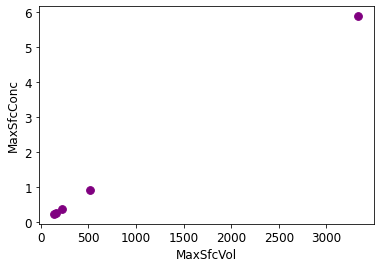

In [14]:
TopSpills[TopSpills['oil_type']=='diesel'].plot.scatter(x='MaxSfcVol',y='MaxSfcConc',s=60, c='purple')

<AxesSubplot:xlabel='MaxSfcVol', ylabel='MaxSfcConc'>

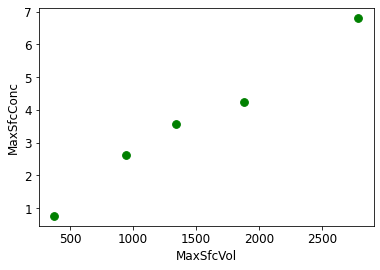

In [15]:
TopSpills[TopSpills['oil_type']=='bunker'].plot.scatter(x='MaxSfcVol',y='MaxSfcConc', 
                                                        s=60, c='green')